# State-Space Model

We may wish to consider another Bayesian setting, but under a markovian setting that evolves over time, namely the latent state space model:

$$
\theta \sim \mathcal{N}(m, P)
$$
$$
x\mid \theta \;\sim\; \mathcal{N}\bigl(C\,\theta,\;Q\bigr)
$$
$$
y\mid x \;\sim\; \mathcal{N}\bigl(A\,x,\;R\bigr)
$$

Where $y$ is observed data, $x$ is latent, and we wish to infer on $\theta$

We first compute the likelihood of y, given by

$$
p(y\mid \theta)
\;=\;\int p(y\mid x)\,p(x\mid \theta)\,dx.
$$

$$
= \int \mathcal{N}\bigl(y; A\,x,\;R\bigr) \mathcal{N}\bigl(x; C\,\theta,\;Q\bigr) dx
$$

$$
= \mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

Now we construct the posterior 

$$
p(\theta\mid y)
\propto
p(\theta) \; p(y\mid \theta)
$$

$$
\propto
\mathcal{N}\bigl(\theta; m \; P )
\;
\mathcal{N}\!\Bigl(
y;\;A\,C\,\theta,\;A\,Q\,A^\top + R
\Bigr)
$$

Using established result, we know

$$
p(\theta\mid y) = \mathcal{N}(y; M, \Sigma)
$$

Where the posterior covariance is given by

$$
\Sigma \;=\;
P - P (AC)^\top \Bigl( A\,Q\,A^\top + R + (AC) P (AC) ^\top \Bigr)^{-1} (AC) P
$$

Or equivalently in a more elegant form

$$
\Sigma \;=\;
\bigl[P^{-1} + C^\top A^\top (A\,Q\,A^\top + R)^{-1} A\,C\bigr]^{-1}.
$$ 

And the posterior mean $M$ is given by

$$
M = m + P (AC)^\top \Bigl( A\,Q\,A^\top + R + (AC) P (AC) ^\top \Bigr)^{-1} (y - ACm)
$$

or more elegantly

$$
M = \Sigma\bigl[P^{-1}m + C^\top A^\top (A\,Q\,A^\top + R)^{-1}y\bigr]
$$


As an example, consider the following parameters:

$$
m = \begin{pmatrix}2 \\[4pt] 0\end{pmatrix},\quad 
P = \begin{pmatrix}1 & 0\\[4pt] 0 & 1\end{pmatrix},\quad
C = \begin{pmatrix}1 & 1\\[4pt] 1 & 1.01\end{pmatrix}
$$

$$
Q = \begin{pmatrix}0.01 & 0\\[4pt] 0 & 0.01\end{pmatrix}
A = \begin{pmatrix}1 & 0 \\[4pt]\varepsilon & 0\end{pmatrix},\quad 
R = \,\begin{pmatrix}\varepsilon & 0\\[4pt] 0 & \varepsilon\end{pmatrix},\quad
$$

And we observed 
$
y = \begin{pmatrix}1\\[3pt]1\end{pmatrix}.
$

In this case we know the posterior is 
$$
p(\theta\mid y) = \mathcal{N}(y; M, \Sigma)
$$
Where $M, \Sigma$ depends on $\epsilon$ and is computed as follow:

In [1]:
import numpy as np
import pandas as pd

m = np.array([[2], [0]])
P = np.eye(2)
C = np.array([[1, 1], [1, 1.01]])
Q = 0.01 * np.eye(2)
y = np.array([[1], [1]])
A_base = np.array([[1, 0], [0, 0]], dtype=float)  # Base part of A
R_base = np.array([[1, 0], [0, 1]], dtype=float)  # Base part of R

epsilons = np.logspace(-3, 0, num=4)  # 10^-3, 10^-2, 10^-1, 10^0
post_var = []
post_means = []

for epsilon in epsilons:
    A = A_base.copy()
    A[1, 0] = epsilon  # Update A with the varying epsilon
    R = epsilon * R_base  # Update R with the varying epsilon
    S = A @ Q @ A.T + R

    Sigma = np.linalg.inv(P + C.T @ A.T @ np.linalg.inv(S) @ A @ C)
    post_var.append(np.round(Sigma, 4))

    post_mean = Sigma @ (np.linalg.inv(P) @ m + C.T @ A.T @ np.linalg.inv(S) @ y)
    post_means.append(np.round(post_mean.flatten(), 4)) # store 4 digits

# Create a DataFrame for visualization
df_post = pd.DataFrame(
    {"Epsilon": epsilons, 
    "Posterior Mean": post_means,
     "Posterior Variance": post_var}
    )
df_post

Epsilon     Posterior Mean                      Posterior Variance
0    0.001  [1.5032, -0.4968]  [[0.5027, -0.4973], [-0.4973, 0.5027]]
1    0.010  [1.5099, -0.4901]      [[0.505, -0.495], [-0.495, 0.505]]
2    0.100  [1.5681, -0.4319]  [[0.5258, -0.4742], [-0.4742, 0.5258]]
3    1.000  [1.6016, -0.3984]  [[0.6016, -0.3984], [-0.3984, 0.6016]]

With $\epsilon=1$, we have
$$
p(\theta\mid y) = \mathcal{N}(y; 
\begin{pmatrix}1.6 \\[4pt] -0.4 \end{pmatrix}, 
\begin{pmatrix}0.6 & -0.4 \\[4pt]-0.4 & 0.6\end{pmatrix}
)
$$

And we plot the posterior:

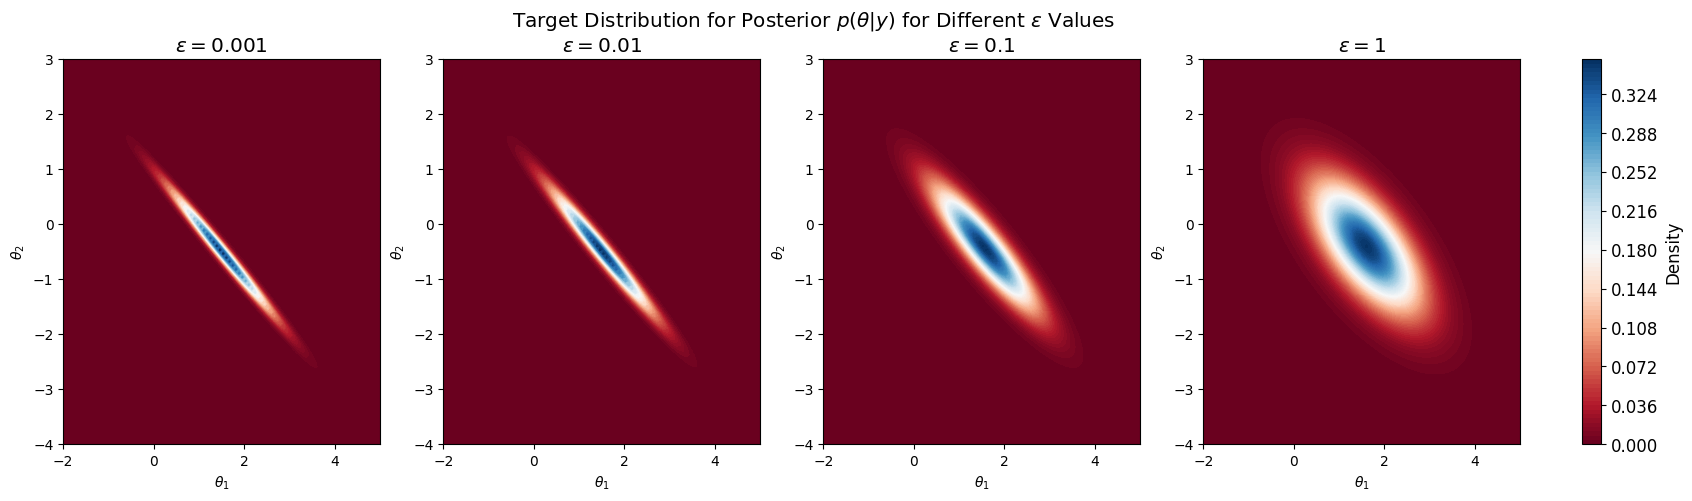

In [2]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

# Define grid for contour plot
x_bb = np.linspace(-2, 5, 100)
y_bb = np.linspace(-4, 3, 100)
X_bb, Y_bb = np.meshgrid(x_bb, y_bb)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
plt.rcParams.update({'font.size': 12})  # Set font size

for i in df_post.index:
    eps = df_post['Epsilon'][i]
    post_mean = df_post['Posterior Mean'][i]
    post_var = df_post['Posterior Variance'][i]

    rv = multivariate_normal(mean=post_mean, cov=post_var)

    # Evaluate the posterior density on the grid
    pos = np.dstack((X_bb, Y_bb))
    Z_bb = rv.pdf(pos)

    # Plot the contour
    ax = axes[i]
    cnt = ax.contourf(X_bb, Y_bb, Z_bb, 100, cmap='RdBu')
    ax.set_title(f'$\\epsilon = {eps:.3g}$')
    ax.set_xlabel('$\\theta_1$')
    ax.set_ylabel('$\\theta_2$')

fig.colorbar(cnt, ax=axes, orientation='vertical', fraction=0.02, pad=0.04, label='Density')
plt.suptitle('Target Distribution for Posterior $p(\\theta | y)$ for Different $\\epsilon$ Values')
plt.show()


Now consider $\epsilon=1$. 

We can sample from the posterior if we know the analytical form.

Assume we don't